In [1]:
"""
runSPKF: Runs a sigma-point Kalman filter
"""
import ipdb, json
import numpy.matlib
import time as pylib_time
import numpy as np
import pandas as pd
import scipy.io as sio 
import matplotlib.pyplot as plt
from scipy import interpolate,stats
from scipy.linalg import cholesky
from pathlib import Path
execution_start_time = pylib_time.time()


In [2]:
# can data extraction 
c_df = pd.read_csv('../data/can_data/can_data_20231212.csv')
#print(c_df.columns[c_df.columns.str.startswith('cell_vtg')])
c_df[c_df.columns[c_df.columns.str.startswith('cell_vtg')]] /= 1e4
c_df.head()

,time,cell_vtg_1,cell_vtg_2,cell_vtg_3,cell_vtg_4,cell_vtg_5,cell_vtg_6,cell_vtg_7,cell_vtg_8,cell_vtg_9,...,cell_vtg_15,soh,charging_capAh,discharging_capAh,soc,charging_Status,tmp_max,tmp_min,pack_voltage,pack_current
0,18:00:59:585,3.359,3.361,3.363,3.363,3.362,3.363,3.364,3.363,3.362,...,3.361,9900.0,85.0,77.0,0.0,1.0,26.0,24.0,504.0,4960000.0
1,18:00:59:773,3.359,3.361,3.363,3.363,3.362,3.363,3.364,3.363,3.362,...,3.361,9900.0,85.0,77.0,0.0,1.0,26.0,24.0,504.0,4960000.0
2,18:01:00:020,3.360,3.361,3.362,3.363,3.362,3.363,3.364,3.363,3.362,...,3.361,9900.0,85.0,77.0,0.0,1.0,26.0,24.0,504.0,4960000.0
3,18:01:00:238,3.360,3.361,3.363,3.363,3.362,3.363,3.364,3.363,3.361,...,3.361,9900.0,85.0,77.0,0.0,1.0,26.0,24.0,504.0,4950000.0
4,18:01:00:489,3.360,3.361,3.362,3.363,3.363,3.363,3.364,3.363,3.362,...,3.361,9900.0,85.0,77.0,0.0,1.0,26.0,24.0,504.0,4950000.0


In [3]:
c_df['time'] = pd.to_datetime(c_df['time'], format='%H:%M:%S:%f')
# Calculate relative time from the reference of the first time
ref_time = c_df['time'].iloc[0]  # Reference time (first time)
c_df['time'] = (c_df['time'] - ref_time).dt.total_seconds()

In [4]:
'''''
c_voltage_column= c_df.columns[c_df.columns.str.startswith('cell_vtg')]
'''

"''\nc_voltage_column= c_df.columns[c_df.columns.str.startswith('cell_vtg')]\n"

In [5]:
'''''
c_voltage_column[0]
'''

"''\nc_voltage_column[0]\n"

In [6]:
for i in range(1,len(c_df.columns.str.startswith('cell_vtg'))+1):
    c_df.rename(columns={f'cell_vtg_{i}':f'Cell Voltage {i}'},inplace='True')
c_df.rename(columns={'time':'Time'},inplace='True')
c_df.head()


,Time,Cell Voltage 1,Cell Voltage 2,Cell Voltage 3,Cell Voltage 4,Cell Voltage 5,Cell Voltage 6,Cell Voltage 7,Cell Voltage 8,Cell Voltage 9,...,Cell Voltage 15,soh,charging_capAh,discharging_capAh,soc,charging_Status,tmp_max,tmp_min,pack_voltage,pack_current
0,0.000,3.359,3.361,3.363,3.363,3.362,3.363,3.364,3.363,3.362,...,3.361,9900.0,85.0,77.0,0.0,1.0,26.0,24.0,504.0,4960000.0
1,0.188,3.359,3.361,3.363,3.363,3.362,3.363,3.364,3.363,3.362,...,3.361,9900.0,85.0,77.0,0.0,1.0,26.0,24.0,504.0,4960000.0
2,0.435,3.360,3.361,3.362,3.363,3.362,3.363,3.364,3.363,3.362,...,3.361,9900.0,85.0,77.0,0.0,1.0,26.0,24.0,504.0,4960000.0
3,0.653,3.360,3.361,3.363,3.363,3.362,3.363,3.364,3.363,3.361,...,3.361,9900.0,85.0,77.0,0.0,1.0,26.0,24.0,504.0,4950000.0
4,0.904,3.360,3.361,3.362,3.363,3.363,3.363,3.364,3.363,3.362,...,3.361,9900.0,85.0,77.0,0.0,1.0,26.0,24.0,504.0,4950000.0


In [7]:
''''
plt.figure(figsize=(15,10))
for i in range (len(c_voltage_column)):
    cId=c_voltage_column[i]
    plt.plot(c_df['time'],c_df[cId]/1e4,label=cId)
plt.legend(loc='center right')
plt.grid('True')
'''

"'\nplt.figure(figsize=(15,10))\nfor i in range (len(c_voltage_column)):\n    cId=c_voltage_column[i]\n    plt.plot(c_df['time'],c_df[cId]/1e4,label=cId)\nplt.legend(loc='center right')\nplt.grid('True')\n"

In [8]:
# Ev data code start from here 
df = pd.read_csv('../data/EV_DATA/719/cellvoltages_2023-12-15-18-39-29.csv')

In [9]:
df = pd.read_csv('../data/EV_DATA/698/cellvoltages_2023-11-30-10-34-46.csv')


In [10]:
df.dropna(axis=1,how='all',inplace=True)

In [11]:
df.columns = df.columns.str.strip()

In [12]:
df['ts']=df['Time']
df.head()

,Time,State of Charge,Pack Voltage,Pack Current,Pack CCL,Pack DCL,Highest Cell ID,Highest Cell Volt,Lowest Cell ID,Lowest Cell Volt,...,Open Cell Voltage 15,Open Cell Voltage 16,Open Cell Voltage 17,Open Cell Voltage 18,Open Cell Voltage 19,Open Cell Voltage 20,Open Cell Voltage 21,Open Cell Voltage 22,Open Cell Voltage 23,ts
0,Thu Nov 30 10:34:58 IST 2023,24.5,67.4,0.0,0,0,9,3.0006,8,2.8567,...,2.9366,2.9491,2.9371,2.9345,2.9217,2.9359,2.9371,2.9357,2.9413,Thu Nov 30 10:34:58 IST 2023
1,Thu Nov 30 10:34:58 IST 2023,24.5,67.4,0.0,0,0,9,2.9932,8,2.8641,...,2.9366,2.9492,2.9372,2.9345,2.9216,2.9359,2.9371,2.9357,2.9412,Thu Nov 30 10:34:58 IST 2023
2,Thu Nov 30 10:34:59 IST 2023,24.5,67.4,0.0,0,0,9,2.9903,8,2.8672,...,2.9366,2.9492,2.9372,2.9345,2.9216,2.9359,2.9371,2.9357,2.9412,Thu Nov 30 10:34:59 IST 2023
3,Thu Nov 30 10:34:59 IST 2023,24.5,67.4,0.0,0,0,9,2.9893,8,2.8680,...,2.9366,2.9492,2.9372,2.9345,2.9216,2.9359,2.9371,2.9357,2.9412,Thu Nov 30 10:34:59 IST 2023
4,Thu Nov 30 10:35:00 IST 2023,24.5,67.4,0.0,0,0,9,2.9890,8,2.8684,...,2.9366,2.9492,2.9372,2.9345,2.9216,2.9359,2.9371,2.9357,2.9412,Thu Nov 30 10:35:00 IST 2023


In [13]:
df['Time'] = df['Time'].str.replace('IST', '+0530')

In [14]:
df['Time'] = pd.to_datetime(df['Time'], format='%a %b %d %H:%M:%S %z %Y', errors='coerce')

In [15]:
df['ts']=df['Time'].astype(np.int64)//10**9

In [16]:
df.head()

,Time,State of Charge,Pack Voltage,Pack Current,Pack CCL,Pack DCL,Highest Cell ID,Highest Cell Volt,Lowest Cell ID,Lowest Cell Volt,...,Open Cell Voltage 15,Open Cell Voltage 16,Open Cell Voltage 17,Open Cell Voltage 18,Open Cell Voltage 19,Open Cell Voltage 20,Open Cell Voltage 21,Open Cell Voltage 22,Open Cell Voltage 23,ts
0,2023-11-30 10:34:58+05:30,24.5,67.4,0.0,0,0,9,3.0006,8,2.8567,...,2.9366,2.9491,2.9371,2.9345,2.9217,2.9359,2.9371,2.9357,2.9413,1701320698
1,2023-11-30 10:34:58+05:30,24.5,67.4,0.0,0,0,9,2.9932,8,2.8641,...,2.9366,2.9492,2.9372,2.9345,2.9216,2.9359,2.9371,2.9357,2.9412,1701320698
2,2023-11-30 10:34:59+05:30,24.5,67.4,0.0,0,0,9,2.9903,8,2.8672,...,2.9366,2.9492,2.9372,2.9345,2.9216,2.9359,2.9371,2.9357,2.9412,1701320699
3,2023-11-30 10:34:59+05:30,24.5,67.4,0.0,0,0,9,2.9893,8,2.8680,...,2.9366,2.9492,2.9372,2.9345,2.9216,2.9359,2.9371,2.9357,2.9412,1701320699
4,2023-11-30 10:35:00+05:30,24.5,67.4,0.0,0,0,9,2.9890,8,2.8684,...,2.9366,2.9492,2.9372,2.9345,2.9216,2.9359,2.9371,2.9357,2.9412,1701320700


In [17]:
df['Pack Current']

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
35598    0.0
35599    0.0
35600    0.0
35601    0.0
35602    0.0
Name: Pack Current, Length: 35603, dtype: float64

In [18]:
f_df=pd.read_csv('../data/NESS_93.csv')

In [19]:
for i in range(1,len(f_df.columns.str.startswith('strv'))+1):
    strvol =f'strv_{i}'
    if strvol in f_df.columns:
        f_df[f'strv_{i}']=f_df[f'strv_{i}']/1000
    f_df.rename(columns={f'strv_{i}':f'Cell Voltage {i}'},inplace='True')

f_df['Time']=(f_df['ts']-f_df['ts'][0])/1000

f_df.head()

,ts,ic,id,lv,soc,tmp,Cell Voltage 1,Cell Voltage 2,Cell Voltage 3,Cell Voltage 4,...,Cell Voltage 8,Cell Voltage 9,Cell Voltage 10,Cell Voltage 11,Cell Voltage 12,Cell Voltage 13,Cell Voltage 14,Cell Voltage 15,Cell Voltage 16,Time
0,1703099565124,0.0,2340.0,52480.0,40.0,19.7,3.28,3.281,3.281,3.281,...,3.280,3.267,3.280,3.281,3.281,3.281,3.280,3.281,3.281,0.000
1,1703099575160,0.0,2340.0,52480.0,40.0,19.7,3.28,3.281,3.281,3.281,...,3.280,3.267,3.281,3.281,3.281,3.281,3.281,3.281,3.281,10.036
2,1703099585195,0.0,2340.0,52470.0,40.0,19.7,3.28,3.281,3.281,3.281,...,3.279,3.267,3.280,3.281,3.281,3.281,3.280,3.281,3.281,20.071
3,1703099595231,0.0,2320.0,52480.0,40.0,19.7,3.28,3.281,3.281,3.281,...,3.280,3.267,3.280,3.281,3.281,3.281,3.281,3.281,3.281,30.107
4,1703099605264,0.0,2330.0,52480.0,40.0,19.7,3.28,3.281,3.281,3.281,...,3.280,3.267,3.281,3.281,3.281,3.281,3.281,3.281,3.281,40.140


In [20]:
#df=c_df
df=f_df

In [21]:
voltage_columns = df.columns[df.columns.str.startswith('Cell Voltage')]

In [22]:
voltage_columns

Index(['Cell Voltage 1', 'Cell Voltage 2', 'Cell Voltage 3', 'Cell Voltage 4',
       'Cell Voltage 5', 'Cell Voltage 6', 'Cell Voltage 7', 'Cell Voltage 8',
       'Cell Voltage 9', 'Cell Voltage 10', 'Cell Voltage 11',
       'Cell Voltage 12', 'Cell Voltage 13', 'Cell Voltage 14',
       'Cell Voltage 15', 'Cell Voltage 16'],
      dtype='object')

In [23]:
df.dropna(subset=voltage_columns, how='any', inplace=True)


In [24]:
df=df.reset_index(drop='True')

In [25]:
df.head()

,ts,ic,id,lv,soc,tmp,Cell Voltage 1,Cell Voltage 2,Cell Voltage 3,Cell Voltage 4,...,Cell Voltage 8,Cell Voltage 9,Cell Voltage 10,Cell Voltage 11,Cell Voltage 12,Cell Voltage 13,Cell Voltage 14,Cell Voltage 15,Cell Voltage 16,Time
0,1703099565124,0.0,2340.0,52480.0,40.0,19.7,3.28,3.281,3.281,3.281,...,3.280,3.267,3.280,3.281,3.281,3.281,3.280,3.281,3.281,0.000
1,1703099575160,0.0,2340.0,52480.0,40.0,19.7,3.28,3.281,3.281,3.281,...,3.280,3.267,3.281,3.281,3.281,3.281,3.281,3.281,3.281,10.036
2,1703099585195,0.0,2340.0,52470.0,40.0,19.7,3.28,3.281,3.281,3.281,...,3.279,3.267,3.280,3.281,3.281,3.281,3.280,3.281,3.281,20.071
3,1703099595231,0.0,2320.0,52480.0,40.0,19.7,3.28,3.281,3.281,3.281,...,3.280,3.267,3.280,3.281,3.281,3.281,3.281,3.281,3.281,30.107
4,1703099605264,0.0,2330.0,52480.0,40.0,19.7,3.28,3.281,3.281,3.281,...,3.280,3.267,3.281,3.281,3.281,3.281,3.281,3.281,3.281,40.140


In [26]:
df['Cell Voltage 2']

0       3.281
1       3.281
2       3.281
3       3.281
4       3.281
        ...  
8249    3.238
8250    3.238
8251    3.238
8252    3.238
8253    3.238
Name: Cell Voltage 2, Length: 8254, dtype: float64

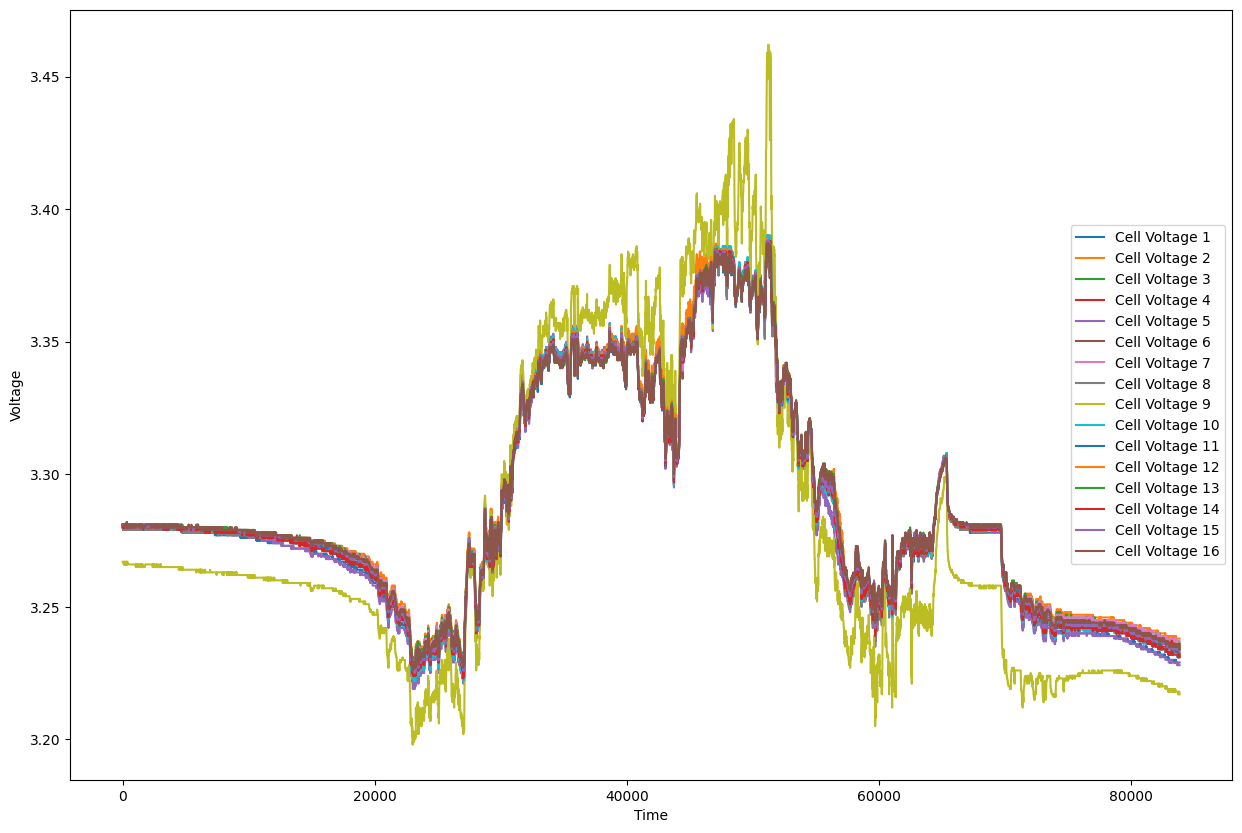

In [27]:
plt.figure(figsize=(15,10))
for i in range(len(voltage_columns)):
    column_name = voltage_columns[i]  # Generate the column name dynamically
    plt.plot(df['Time'], df[column_name], label=column_name)
plt.xlabel('Time')
plt.ylabel('Voltage')
plt.legend(loc='center right')
plt.show()

In [28]:
''''
import pandas as pd
import numpy as np

# Creating a sample DataFrame with 4 columns
np.random.seed(42)
data = np.random.randint(0, 100, size=(100, 4))
df = pd.DataFrame(data, columns=['Column_1', 'Column_2', 'Column_3', 'Column_4'])

# Define the fluctuation limit
fluctuation_limit = 20

# Loop through each column in the DataFrame
for col in df.columns:
    # Calculate rolling local maxima and minima using a window of 10 points
    rolling_max = df[col].rolling(window=10, min_periods=1).max()
    rolling_min = df[col].rolling(window=10, min_periods=1).min()

    # Find the differences between consecutive maxima and minima
    diff_max = rolling_max.diff()
    diff_min = rolling_min.diff()

    # Determine indices where fluctuations occur based on the limit
    fluctuating_indices = (diff_max > fluctuation_limit) | (diff_min < -fluctuation_limit)

    # Extract the indices of local maxima and minima where fluctuations occur
    fluctuating_maxima = rolling_max[fluctuating_indices]
    fluctuating_minima = rolling_min[fluctuating_indices]

    print(f"Column: {col}")
    print("Indices of fluctuating local maxima:")
    print(fluctuating_maxima.dropna().index.tolist())

    print("Indices of fluctuating local minima:")
    print(fluctuating_minima.dropna().index.tolist())
    print("\n")

'''

'\'\nimport pandas as pd\nimport numpy as np\n\n# Creating a sample DataFrame with 4 columns\nnp.random.seed(42)\ndata = np.random.randint(0, 100, size=(100, 4))\ndf = pd.DataFrame(data, columns=[\'Column_1\', \'Column_2\', \'Column_3\', \'Column_4\'])\n\n# Define the fluctuation limit\nfluctuation_limit = 20\n\n# Loop through each column in the DataFrame\nfor col in df.columns:\n    # Calculate rolling local maxima and minima using a window of 10 points\n    rolling_max = df[col].rolling(window=10, min_periods=1).max()\n    rolling_min = df[col].rolling(window=10, min_periods=1).min()\n\n    # Find the differences between consecutive maxima and minima\n    diff_max = rolling_max.diff()\n    diff_min = rolling_min.diff()\n\n    # Determine indices where fluctuations occur based on the limit\n    fluctuating_indices = (diff_max > fluctuation_limit) | (diff_min < -fluctuation_limit)\n\n    # Extract the indices of local maxima and minima where fluctuations occur\n    fluctuating_maxima =

Safe: Cell Voltage 1
Safe: Cell Voltage 2
Safe: Cell Voltage 3
Safe: Cell Voltage 4
Safe: Cell Voltage 5
Safe: Cell Voltage 6
Safe: Cell Voltage 7
Safe: Cell Voltage 8
Daviation detected in Cell Voltage 9 measurements
Resistance issue detected
Safe: Cell Voltage 10
Safe: Cell Voltage 11
Safe: Cell Voltage 12
Safe: Cell Voltage 13
Safe: Cell Voltage 14
Safe: Cell Voltage 15
Safe: Cell Voltage 16


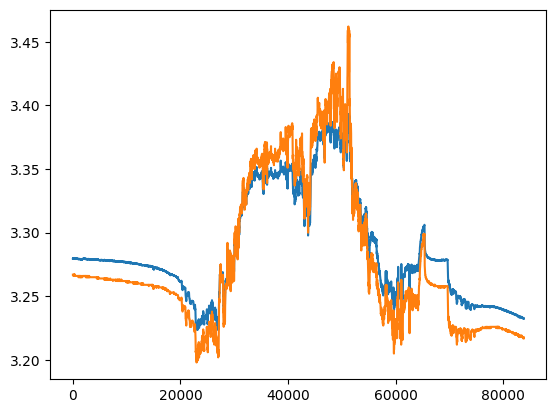

<Figure size 640x480 with 0 Axes>

In [29]:
df['Mean Selected']=df[voltage_columns].mean(axis=1)
plt.plot (df['Time'],df['Mean Selected'])
plt.plot (df['Time'],df['Cell Voltage 9'])
lowest_voltage_check= df[df['Mean Selected']<df['Mean Selected'].min()+0.02]
higest_voltage_check =df[df['Mean Selected']>df['Mean Selected'].max()-0.02]
voltage_z_score=stats.zscore(lowest_voltage_check[voltage_columns],axis=1)
plt.figure()
zscore_lower_limit=-1
zscore_upper_limit =1
difference_limit=0.1
for col in voltage_z_score.columns:
   # Calculate Z-scores for each voltage column
   z_scores_col = (voltage_z_score[col])
   # Calculate the average Z-score for the current voltage column
   average_zscore_col = z_scores_col.mean()
   # Check if the average Z-score exceeds the limit
   if zscore_lower_limit <average_zscore_col < zscore_upper_limit:
      print(f"Safe: {col}")
   else:
      print(f"Daviation detected in {col} measurements")
      rolling_max = lowest_voltage_check[col].rolling(window=10, min_periods=1).max()
      rolling_min = lowest_voltage_check[col].rolling(window=10, min_periods=1).min()
      diff_max_min = (rolling_max-rolling_min).mean()
      if diff_max_min>difference_limit:
         print(f"Sensor Error detected in {col} measurements")
      else:
         if lowest_voltage_check[col].mean()<lowest_voltage_check['Mean Selected'].mean() and higest_voltage_check[col].mean()>higest_voltage_check['Mean Selected'].mean():
            print ("Resistance issue detected")
         else:
            print(" Check for disconnection issue")
         
      